In [1]:
import os
import json
import warnings 
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['axes.grid'] = False

In [5]:
%matplotlib inline

dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'
anns_train = dataset_path + '/' + 'train.json'
anns_val = dataset_path + '/' + 'val.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
with open(anns_train, 'r') as g:
    dataset_train = json.loads(g.read())
with open(anns_val, 'r') as h:
    dataset_val = json.loads(h.read())

categories = dataset['categories']

anns_full = dataset['annotations']
anns_train = dataset_train['annotations']
anns_val = dataset_val['annotations']

imgs = dataset['images']
imgs_train = dataset_train['images']
imgs_val = dataset_val['images']

nr_cats = len(categories)
nr_annotations = len(anns_full)
nr_annotations_train = len(anns_train)
nr_annotations_val = len(anns_val)
nr_images = len(imgs)
nr_images_train = len(imgs_train)
nr_images_val = len(imgs_val)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


In [6]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
cat_histogram_train = np.zeros(nr_cats,dtype=int)
cat_histogram_val = np.zeros(nr_cats, dtype = int)
for ann in anns_full:
    cat_histogram[ann['category_id']-1] += 1
for ann in anns_train:
    cat_histogram_train[ann['category_id']-1]+=1
for ann in anns_val:
    cat_histogram_val[ann['category_id']-1]+=1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df["Number of annotations"] = df["Number of annotations"].apply(lambda x : x/nr_annotations)
df = df.sort_values('Number of annotations', 0, False)

df_train = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram_train})
df_train["Number of annotations"] = df_train["Number of annotations"].apply(lambda x : x/nr_annotations_train)
df_train = df_train.sort_values('Number of annotations', 0, False)

df_val = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram_val})
df_val["Number of annotations"] = df_val["Number of annotations"].apply(lambda x : x/nr_annotations_val)
df_val = df_val.sort_values('Number of annotations', 0, False)

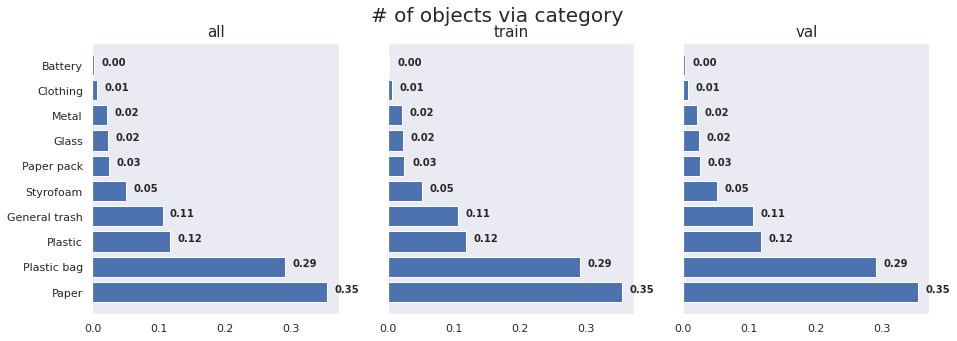

In [23]:
f,ax = plt.subplots(1,3,figsize = (15,5))
plt.suptitle('# of objects via category',fontsize=20)
x = df['Number of annotations']
y = df['Categories']
x_train = df_train['Number of annotations']
x_val = df_train['Number of annotations']
ax[0].barh(y,x)
ax[0].set_title('all',{'fontsize': 15})
ax[1].barh(y,x_train)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('train',{'fontsize': 15})
ax[2].barh(y,x_val)
ax[2].axes.yaxis.set_visible(False)
ax[2].set_title('val', {'fontsize': 15})

for i,data in enumerate([x,x_train,x_val]):
     for idx, value in enumerate(data):
          ax[i].text(value+0.03, idx, s="{:.2f}".format(value),
                       ha='center', 
                       fontweight='bold'
                      )

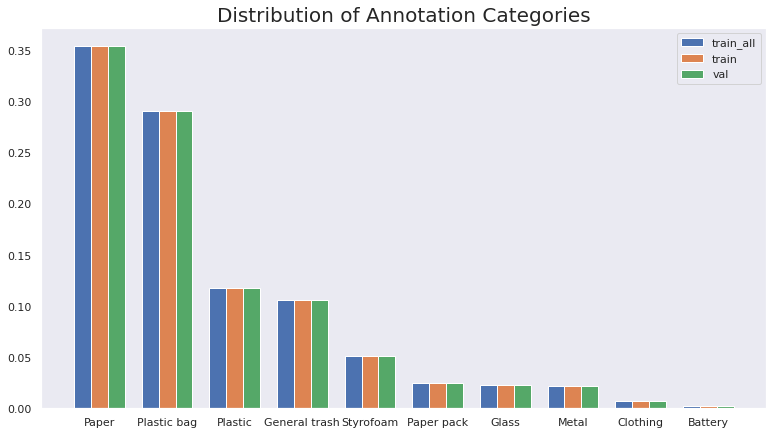

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))
data_list =[df,df_train,df_val]
x = np.arange(len(df['Categories']))
width=0.25

for idx, g in enumerate(data_list):
    ax.bar(x+(-len(data_list)+1+2*idx)*width/2, g["Number of annotations"], 
       width=width, label=g)

ax.set_xticks(x)
ax.set_xticklabels(df['Categories'])
ax.legend(['train_all','train','val'])    
ax.set_title('Distribution of Annotation Categories', {'fontsize':20})
    
plt.show()

In [9]:
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
full_path = dataset_path + '/train_all.json'
coco_train = COCO(train_path)
coco_val = COCO(val_path)
coco_full = COCO(full_path)

loading annotations into memory...
Done (t=4.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
loading annotations into memory...
Done (t=5.20s)
creating index...
index created!


In [10]:
image_id = coco_train.getImgIds(imgIds=0)
image_infos = coco_train.loadImgs(image_id)[0]

# cv2 를 활용하여 image 불러오기
images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images /= 255.0

In [11]:
ann_ids = coco_train.getAnnIds(imgIds=image_infos['id'])
anns = coco_train.loadAnns(ann_ids)
masks = np.zeros((image_infos["height"], image_infos["width"]))
# General trash = 1, ... , Cigarette = 10
pixel_value = anns[8]['category_id']
masks[coco_train.annToMask(anns[8]) == 1] = pixel_value
masks = masks.astype(np.int8)
bbox = anns[8]['bbox']

In [12]:
bbox

[236.5, 209.1, 66.5, 35.2]

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

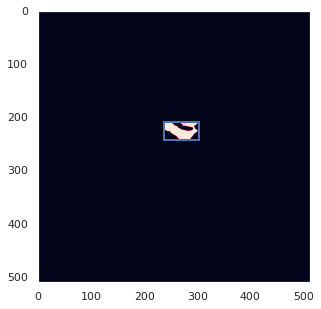

In [13]:
import matplotlib.patches as patches
f,ax = plt.subplots(1,1,figsize=(5,5))
rect = patches.Rectangle((bbox[0],bbox[1]), bbox[2],bbox[3], linewidth=2, edgecolor='b', facecolor='none')
plt.imshow(masks)
ax.add_patch(rect)
plt.imshow

In [14]:
def get_bbox_num(num, coco, name):
    num_bbox=[]
    for idx in range(num):
        image_id = coco.getImgIds(imgIds=idx)
        image_infos = coco.loadImgs(image_id)[0]
        ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
        anns = coco.loadAnns(ann_ids)
        num_bbox.append([len(anns),name])
    return num_bbox

In [15]:
num_bbox_full = get_bbox_num(nr_images, coco_full, 'full')
num_bbox_train = get_bbox_num(nr_images_train, coco_train, 'train')
num_bbox_val = get_bbox_num(nr_images_val, coco_val, 'val')

df_bbox_full = pd.DataFrame(num_bbox_full, columns=['Bbox','Dataset'])
df_bbox_train = pd.DataFrame(num_bbox_train,columns=['Bbox','Dataset'])
df_bbox_val = pd.DataFrame(num_bbox_val,columns = ['Bbox','Dataset'])
df_bbox = pd.concat([df_bbox_full,df_bbox_train,df_bbox_val])

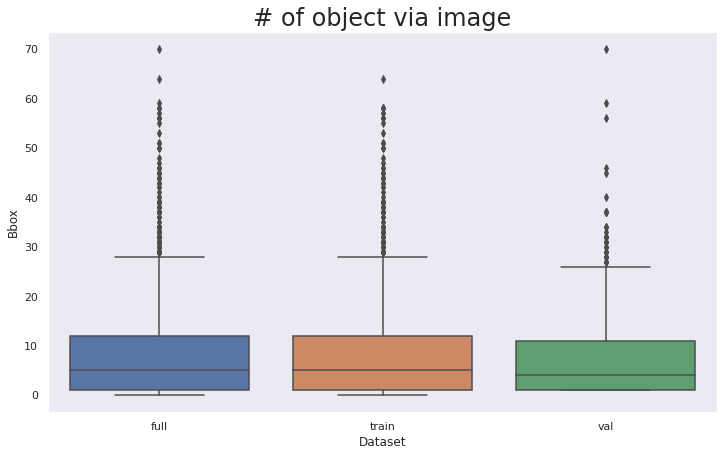

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
sns.boxplot(x='Dataset', y='Bbox', data=df_bbox, ax=ax)
ax.set_title('# of object via image', fontsize=24)
plt.show()

In [17]:
def area_dist(annotations, name):
    hist=[]
    for ann in annotations:
        cat = super_cat_names[ann['category_id']-1]
        hist.append([ann['area'],cat,name])
    return hist

In [18]:
area_hist_full = area_dist(anns_full, 'full')
area_hist_train = area_dist(anns_train, 'train')
area_hist_val = area_dist(anns_val, 'val')

In [19]:
df_area_full = pd.DataFrame(area_hist_full, columns=['Area','Category','Dataset'])
df_area_train = pd.DataFrame(area_hist_train,columns=['Area','Category','Dataset'])
df_area_val = pd.DataFrame(area_hist_val,columns = ['Area','Category','Dataset'])
df_area = pd.concat([df_area_full,df_area_train,df_area_val])

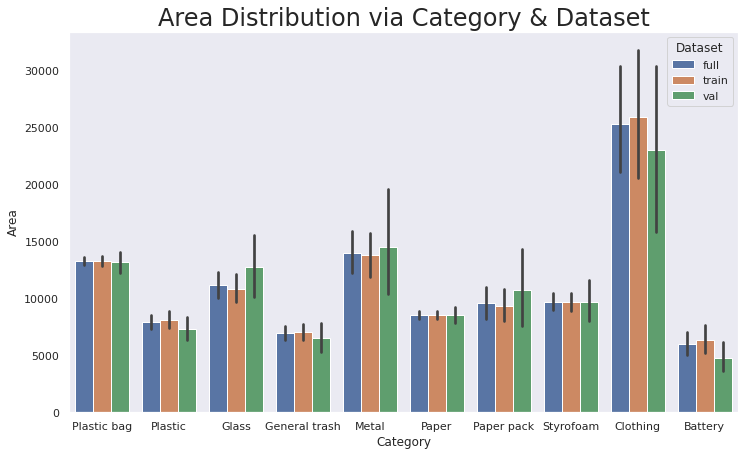

In [28]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
sns.barplot(x='Category', y='Area', data=df_area, ax=ax,
               hue='Dataset'
              )
ax.set_title('Area Distribution via Category & Dataset', fontsize=24)
plt.show()

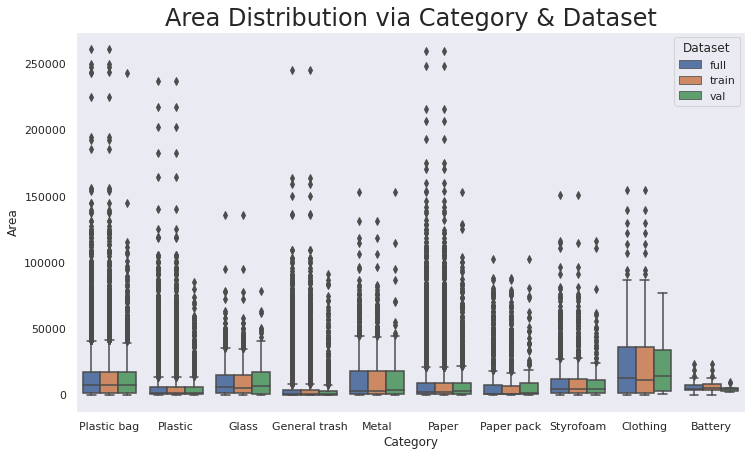

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
sns.boxplot(x='Category', y='Area', data=df_area, ax=ax,
               hue='Dataset'
              )
ax.set_title('Area Distribution via Category & Dataset', fontsize=24)
plt.show()